# Session 9: Support Vector Machines (SVM)

Instruction for using Colab: [Here](https://www.tutorialspoint.com/google_colab/google_colab_quick_guide.htm)

Support vector machines (SVMs) are a particularly powerful and flexible class of supervised algorithms for both classification and regression. In this section, we will develop the intuition behind support vector machines and their use in classification problems.

We begin with the standard imports:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from IPython.display import display, HTML

# use seaborn plotting defaults
import seaborn as sns; sns.set()

## Motivating Support Vector Machines
As part of our disussion of Bayesian classification, we learned a simple model describing the distribution of each underlying class (LDA, and QDA), and used these *generative* models to *probabilistically* determine labels for new points. That was an example of generative classification; here we will consider instead *discriminative* classification: rather than modeling each class, we simply find a hyperplane (line or curve in two dimensions) that divides the classes from each other.

As an example of this, consider the simple case of a classification task, in which the two classes of points are well separated:

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


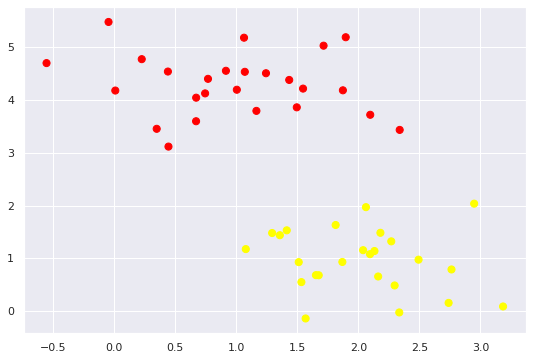

In [2]:
size = plt.figure(figsize = (9,6))
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

Funcrtion `sklearn.datasets.make_blobs` generates isotropic Gaussian blobs (i.e., $\Sigma = \sigma^2\, I$) for clustering. <https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html>

A linear discriminative classifier would attempt to draw a straight line separating the two sets of data, and thereby create a model for (hard) classification. But, like in our example, immediately we see a problem, i.e., there is more than one possible dividing line that can perfectly discriminate between the two classes:

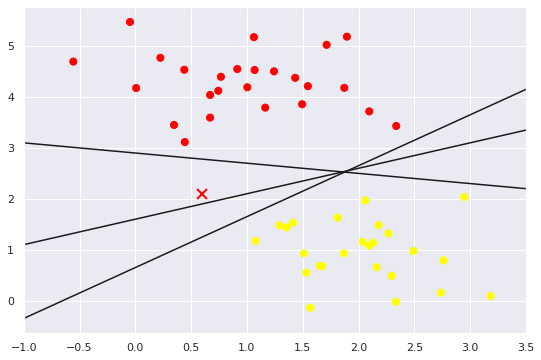

In [3]:
size = plt.figure(figsize = (9,6))
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10) # red cross

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]: # 3 different pairs of (m,b)
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);  # range of x

These are three very different separators which, nevertheless, perfectly discriminate between these samples. Depending on which you choose, a new data point (e.g., the one marked by the "X" in this plot) will be assigned a different label! Evidently our simple intuition of "drawing a line between classes" is not enough, and we need to think a bit deeper.

## Maximizing the Margin
Support vector machines offer one way to improve on this. The intuition is this: rather than simply drawing a zero-width line between the classes, we can draw around each line a margin of some width, up to the nearest point. Here is an example of how this might look:

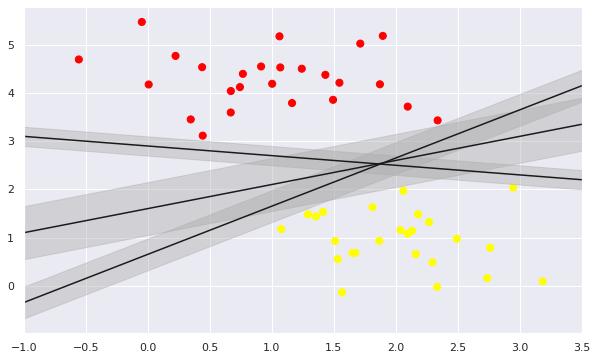

In [4]:
size = plt.figure(figsize=(10,6))
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',  # gives margins
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

In support vector machines, the line that maximizes this margin is the one we will choose as the optimal model. Support vector machines are an example of such a maximum margin estimator.

## Fitting a support vector machine
Let's see the result of an actual fit to this data: we will use Scikit-Learn's support vector classifier to train an SVM model on this data. For the time being, we will use a linear kernel and set the $C$ parameter to a very large number (we'll discuss the meaning of these in more depth momentarily).

In [5]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)
print(1E10)

10000000000.0


To better visualize what's happening here, let's create a quick convenience function that will plot SVM decision boundaries for us:

In [6]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

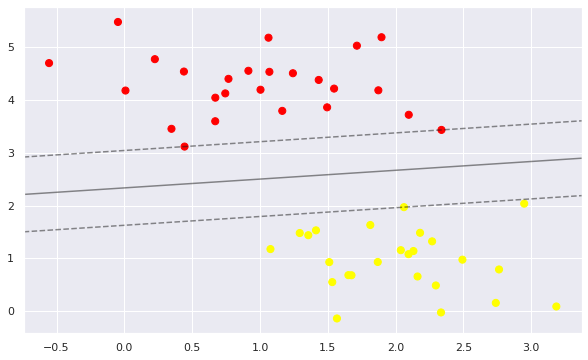

In [7]:
size = plt.figure(figsize=(10,6))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

This is the dividing line that maximizes the margin between the two sets of points. Notice that a few of the training points just touch the margin: they are indicated by the black circles in this figure. These points are the pivotal elements of this fit, and are known as the *support vectors*, and give the algorithm its name. In Scikit-Learn, the identity of these points are stored in the `support_vectors_ attribut` of the classifier:

In [8]:
model.support_vectors_


array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

<span style="color:red">**Important Note**</span> <br>
<span style="color:red">A key to this classifier's success is that for the fit, only the position of the support vectors matter; any points further from the margin which are on the correct side do not modify the fit! Technically, this is because these points do not contribute to the loss function used to fit the model, so their position and number do not matter so long as they do not cross the margin.</span>

We can see this, for example, if we plot the model learned from the first 60 points and first 120 points of this dataset:

<Figure size 576x432 with 0 Axes>

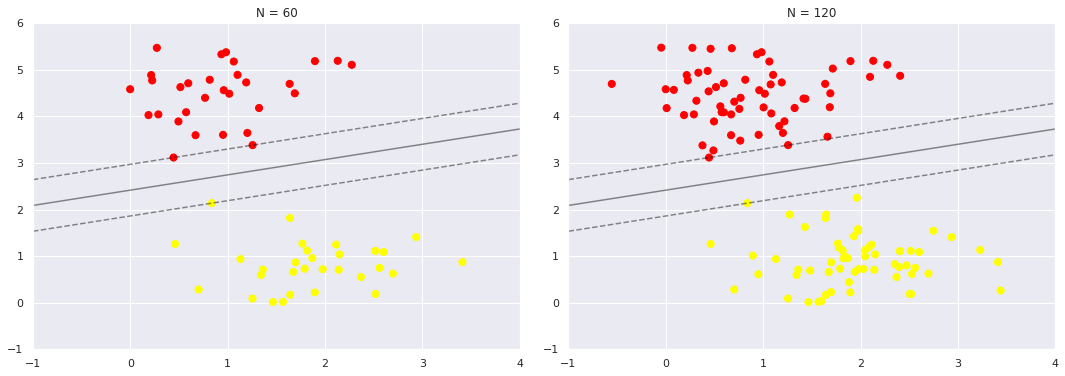

In [9]:
size = plt.figure(figsize=(8,6))
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

In the left panel, we see the model and the support vectors for 60 training points. In the right panel, we have doubled the number of training points, but the model has not changed: the three support vectors from the left panel are still the support vectors for the right panel. This insensitivity to the exact behavior of distant points is one of the strengths of the SVM model.

If you are running this notebook live, you can use IPython's interactive widgets to view this feature of the SVM model interactively:

In [10]:
# size = plt.figure(figsize = (9,9))
from ipywidgets import interact, fixed
interact(plot_svm, N=[10, 20, 50, 150, 200], ax=fixed(None));

interactive(children=(Dropdown(description='N', options=(10, 20, 50, 150, 200), value=10), Output()), _dom_cla…

## Kernel Trick
Where SVM becomes extremely powerful is when it is combined with kernels. For another example of kernel method check the following link which discuss the kernel trick in the context of basis function regressions: <br> <https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html>. 

In that case, the data is projected into higher-dimensional space defined by polynomials and Gaussian basis functions, and thereby we are able to fit a linear classifier to an essensially nonlinear classification relationship.

In SVM models, we can use a version of the same idea. To motivate the need for kernels, let's look at some data that is not linearly separable:

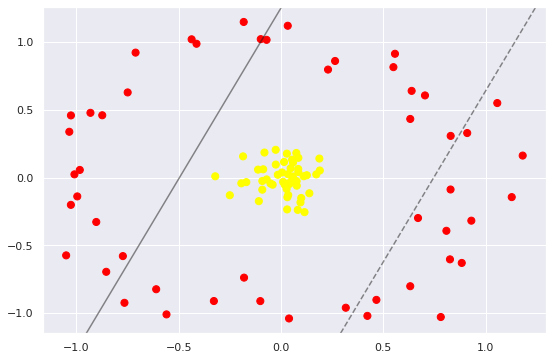

In [11]:
size = plt.figure(figsize = (9,6))
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

It is clear that no linear discrimination will ever be able to separate this data. But we can draw a lesson from the basis function regressions in In Depth: Linear Regression, and think about how we might project the data into a higher dimension such that a linear separator would be sufficient. For example, one simple projection we could use would be to compute a radial basis function centered on the middle clump:

In [12]:
r = np.exp(-(X ** 2).sum(1))

We can visualize this extra data dimension using a three-dimensional plot—if you are running this notebook live, you will be able to use the sliders to rotate the plot:

In [13]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    figsize = plt.figure(figsize=(12,8))
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-90, -45,0,45,90], azip=(-180, -90, 0, 90, 180),
         X=fixed(X), y=fixed(y));

interactive(children=(Dropdown(description='elev', options=(-90, -45, 0, 45, 90), value=-90), IntSlider(value=…

We can see that with this additional dimension, the data becomes trivially linearly separable, by drawing a separating plane at, say, r=0.7.

Here we had to choose and carefully tune our projection: if we had not centered our radial basis function in the right location, we would not have seen such clean, linearly separable results. In general, the need to make such a choice is a problem: we would like to somehow automatically find the best basis functions to use.

One strategy to this end is to compute a basis function centered at every point in the dataset, and let the SVM algorithm sift through the results. This type of basis function transformation is known as a kernel transformation, as it is based on a similarity relationship (or kernel) between each pair of points.

A potential problem with this strategy—projecting N points into N dimensions—is that it might become very computationally intensive as N grows large. However, because of a neat little procedure known as the kernel trick, a fit on kernel-transformed data can be done implicitly—that is, without ever building the full N-dimensional representation of the kernel projection! This kernel trick is built into the SVM, and is one of the reasons the method is so powerful.

In Scikit-Learn, we can apply kernelized SVM simply by changing our linear kernel to an RBF (radial basis function) kernel, using the kernel model hyperparameter:

In [14]:
clf = SVC(kernel='rbf', C=1E6, gamma='auto')
clf.fit(X, y)

SVC(C=1000000.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

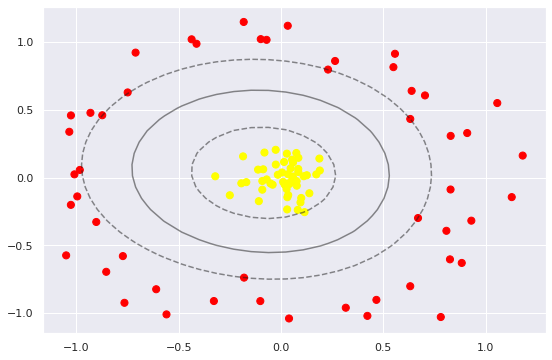

In [15]:
size = plt.figure(figsize = (9,6))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

Using this kernelized support vector machine, we learn a suitable nonlinear decision boundary. This kernel transformation strategy is used often in machine learning to turn fast linear methods into fast nonlinear methods, especially for models in which the kernel trick can be used.

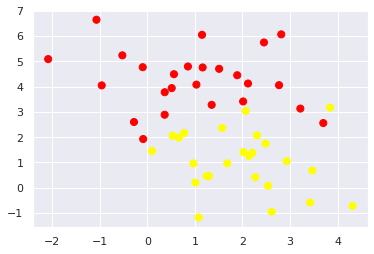

In [16]:
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=1.20)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

In [17]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=10)
model.fit(X, y)
print(1E10)

10000000000.0


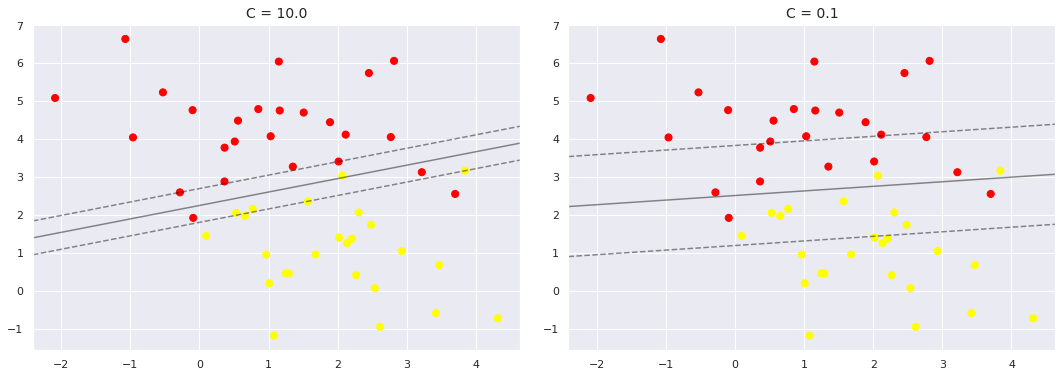

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

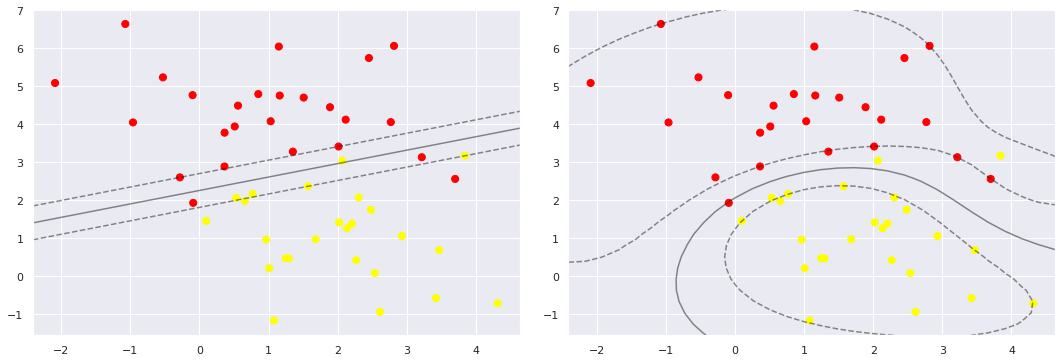

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, k in zip(ax, ['linear', 'rbf']):
    model = SVC(kernel=k, C=10).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    #axi.set_title('k = {0:.1f}'.format(C), size=14)

# Additional Material -1 [Optional]



[GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

In [20]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = svm.SVC()
gd_clf = GridSearchCV(svc, parameters, scoring='accuracy')
gd_clf.fit(X, y)

gd_clf.best_params_

{'C': 1, 'kernel': 'rbf'}

In [21]:
best_model = gd_clf.best_estimator_
y_pred = best_model.predict(X)
y_pred[:5]

array([1, 1, 0, 0, 1])

# Additional Material -2 [Optional]



* [Voting Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html) - heterogeneous type of Ensemble Learning
  * Extension of **Bagging**  

In [22]:
import pandas as pd
diabetes_data = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vSFubekV4eJCKAP63FN2QGO-eEs8GU20yw3uZBkNhrnEorNBerWC_9_k-OBLnZE9US7T-AX9GmnXMah/pub?gid=1985752445&single=true&output=csv')
feature_cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
diabetes_data.columns = feature_cols + ['Outcome']
diabetes_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [23]:
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn.ensemble import StackingClassifier, VotingClassifier , RandomForestClassifier
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix, f1_score, fbeta_score,mean_squared_error, accuracy_score, roc_auc_score


In [24]:
X_diab = diabetes_data[feature_cols] # Features
y_diab = diabetes_data.Outcome # Target variable

In [25]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X_diab, y_diab, test_size=0.3, random_state=1) # 70% training and 30% test

In [26]:
import sklearn
sklearn.__version__

'0.22.2.post1'

In [27]:
clf1 = LogisticRegression()
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = DecisionTreeClassifier(max_depth=10)


vc = VotingClassifier(estimators=[
        ('lr', clf1), ('rf', clf2), ('dt', clf3)], voting='hard')
vc.fit(X_train, y_train)
y_pred = vc.predict(X_test)
accuracy_score(y_test, y_pred)


0.7922077922077922

In [28]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import confusion_matrix, f1_score, fbeta_score,mean_squared_error, accuracy_score
dt3 = DecisionTreeClassifier(max_depth=10)

bag = BaggingClassifier(dt3, n_estimators=100, random_state=1)
bag.fit(X_train, y_train)
y_hat = bag.predict(X_test)
accuracy_score(y_test, y_hat)

0.7705627705627706

In [29]:
vc.named_estimators_['lr']

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [30]:
vc_soft = VotingClassifier(estimators=[
       ('lr', clf1), ('rf', clf2), ('dt', clf3)],
       voting='soft', weights=[2,2,1],
       flatten_transform=True)

vc_soft.fit(X_train, y_train)

y_pred = vc_soft.predict(X_test)
accuracy_score(y_test, y_pred)

0.7965367965367965

# Breakout Room Exercise (30 - 45 Minutes)

1. Load '**wine_255.csv**' dataset on mycourses: mycourses\Content\Data\wine_255.csv
2. You will be working with all the columns in the dataset.

3. Print out the first 10 records and last 5 records/rows of your dataframe.

4. Display some statistics associated with the data.
  * Do you notice something wrong? Fix it.
  * Do you have duplicate entries? Use 

    ```
    pandas - drop_duplicates
    ```
    [documentation - drop_duplicates](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html)

  * How many duplicate entries did you notice?

5. After making proper modification, generate stats associated with all the columns.

6. [Optional] Partition data into two parts : train and test (ratio: 80:20).

7. Train a Decision Tree Classifier model with the target variable being: '**quality_category**'

8. Check model performance on the data: Confusion Matrix, Classification Report.

9. Train a Random Forest Classifier model with the target variable being: '**quality_category**'



--- 
For this week 
--- 
---

10. Perform k- fold CV for hyperparameter search with following parameters using [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html):

  * number of estimators: 10, 20, 50
  * min_samples_split: 2, 3, 5
  * criterion: 'gini', 'entropy'
  * max_leaf_node: 4, 6, 8

* Note: Step 10 can be performed with either 'Decison Tree' or 'Random Forest' classifier. Not all the parameters will be valid. Check documentation and tune accordingly.

11. Train a SVC on the data, with the target variable being: '**quality_category**'.

12. Perform k- fold CV for hyperparameter search of **C** for SVC

13. Fit a [Voting Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html) using

* Logistic Regression
* SVC
* Decision Tree
* Bagging
* Random Forest

14. [Optional] Perform a hyperparameter search for the weights of a Voting Classifier.

* You can use GridSearchCV here.
* Note: you can keep one of the weights fixed and change the rest.

*Or*

14. Simply hand-tune the weights according to your understanding of the algorithms.

* Which of these algorithms cannot handle non-linear relationships, so give a less weight.
* Which one is prone to over-fitting, so less weightage.
* ....

Details: 

**weights: array-like of shape (n_classifiers,), default=None**

Sequence of weights (float or int) to weight the occurrences of predicted class labels (hard voting) or class probabilities before averaging (soft voting). Uses uniform weights if None.



### Part 1-3

In [46]:
wine = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vTEekXMc_rtLkJ6mOydr_WMmYlaIElaUZ3_TS0FAlXmmWiFGoN1qOAmqy5FkQWuo0tLkyXoCGEHeDFM/pub?gid=419498579&single=true&output=csv")
wine.describe()

,Unnamed: 0,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_category
count,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000
mean,3255.125793,7.217755,0.339589,0.318758,5.443958,0.056056,30.516865,115.694492,0.994698,3.218332,0.531150,10.492825,2.177626
std,1869.906597,1.297913,0.164639,0.145252,4.756852,0.035076,17.758815,56.526736,0.003001,0.160650,0.148913,1.193128,0.858450
min,0.000000,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,0.000000
25%,1639.500000,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992330,3.110000,0.430000,9.500000,2.000000
50%,3257.000000,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,2.000000
75%,4872.500000,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.997000,3.320000,0.600000,11.300000,3.000000
max,6496.000000,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,4.000000


In [47]:
wine = wine.dropna()    # drop all null values, there is enough data to ignore the few missing values
wine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6463 entries, 0 to 6462
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            6463 non-null   int64  
 1   type                  6463 non-null   object 
 2   fixed acidity         6463 non-null   float64
 3   volatile acidity      6463 non-null   float64
 4   citric acid           6463 non-null   float64
 5   residual sugar        6463 non-null   float64
 6   chlorides             6463 non-null   float64
 7   free sulfur dioxide   6463 non-null   float64
 8   total sulfur dioxide  6463 non-null   float64
 9   density               6463 non-null   float64
 10  pH                    6463 non-null   float64
 11  sulphates             6463 non-null   float64
 12  alcohol               6463 non-null   float64
 13  quality_category      6463 non-null   int64  
dtypes: float64(11), int64(2), object(1)
memory usage: 757.4+ KB


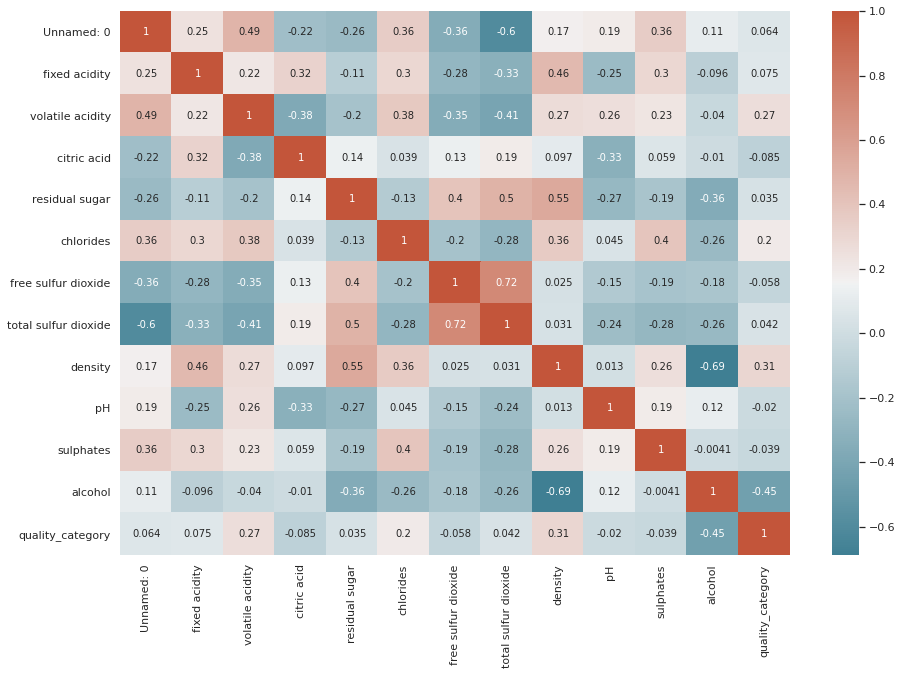

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
corr = wine.corr()
plt.subplots(figsize=(15,10))
sns.heatmap(corr, 
            xticklabels=corr.columns, 
            yticklabels=corr.columns, 
            annot=True, 
            cmap = sns.diverging_palette(220, 20, as_cmap=True))

In [49]:
wine.drop(['Unnamed: 0'], axis=1,inplace=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb0f89dd290>,
      dtype=object)

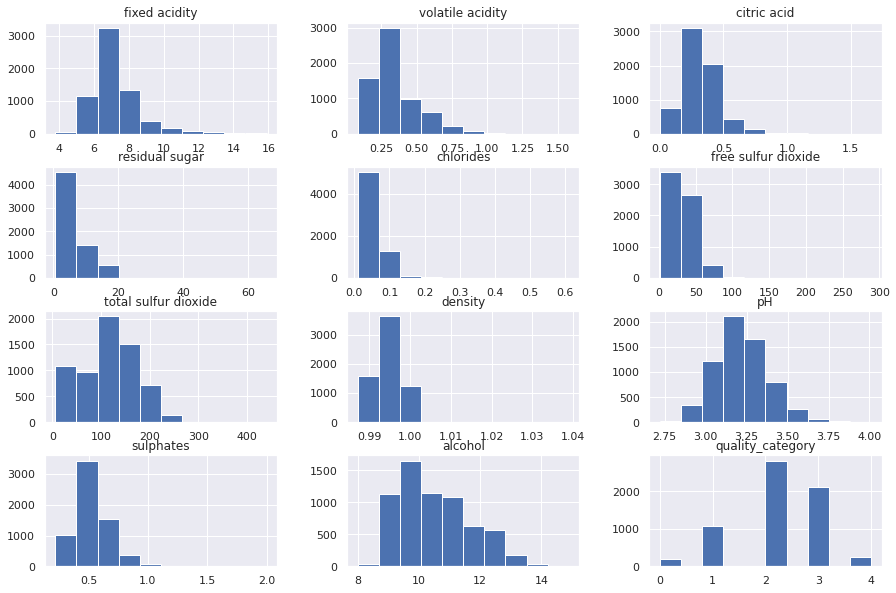

In [50]:
plt.rcParams['figure.figsize'] = [15, 10]
wine.hist()

### Part - 4

In [51]:
wine_clean = wine.copy()
to_exclude = pd.DataFrame()

for col in wine_clean.drop('type', axis=1):
    
    std = wine_clean[col].std()
    mean = wine_clean[col].mean()
    
    print(f"standard dev for {col} is {std}")
    
    above = wine_clean[col] > (mean + 4.72*std)
    below = wine_clean[col] < (mean - 4.72*std)
    
    print(f"For {col}, everything above 4.72std from mean = {(mean + 4.72*std)} has df of shape {wine_clean[above].shape}")
    print(f"For {col}, everything under -4.72std from mean = {(mean - 4.72*std)} has df of shape {wine_clean[below].shape}\n\n")
    
    to_exclude = to_exclude.append(wine_clean[above])
    to_exclude = to_exclude.append(wine_clean[below])

standard dev for fixed acidity is 1.2979130645332086
For fixed acidity, everything above 4.72std from mean = 13.343904577176028 has df of shape (15, 13)
For fixed acidity, everything under -4.72std from mean = 1.0916052479825389 has df of shape (0, 13)


standard dev for volatile acidity is 0.16463923980300144
For volatile acidity, everything above 4.72std from mean = 1.1166864119320579 has df of shape (7, 13)
For volatile acidity, everything under -4.72std from mean = -0.4375080118082758 has df of shape (0, 13)


standard dev for citric acid is 0.14525227686780018
For citric acid, everything above 4.72std from mean = 1.0043482897527278 has df of shape (2, 13)
For citric acid, everything under -4.72std from mean = -0.36683320387930574 has df of shape (0, 13)


standard dev for residual sugar is 4.75685168668683
For residual sugar, everything above 4.72std from mean = 27.896297875443153 has df of shape (3, 13)
For residual sugar, everything under -4.72std from mean = -17.00838204688052 

In [52]:
# which ones are repeated?
unique_indices = to_exclude.index.unique()
if to_exclude.shape[0] != len(unique_indices):
    print("There are redundant samples.")
    to_exclude.reset_index(inplace=True)
    
    # drop redudant samples from outliers dataframe
    to_exclude.drop_duplicates(subset='index', inplace=True)
    
    # drop outliers from clean dataframe
    wine_clean = pd.concat([wine_clean.reset_index(), to_exclude]).drop_duplicates(subset='index', keep=False)

wine_clean.set_index('index', inplace=True)
wine_clean.head()

There are redundant samples.


,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_category
index,,,,,,,,,,,,,
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,2
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,2
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,2
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,2
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,2


In [53]:
# Next, create numerical encoding for variables
wine_clean['red_wine'] = pd.get_dummies(wine_clean['type'])['red']
wine_clean.drop('type', axis=1, inplace=True)
wine_clean.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_category,red_wine
index,,,,,,,,,,,,,
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,2,0
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,2,0
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,2,0
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,2,0
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,2,0


In [54]:
# Drop out duplicate entries

wine_clean.drop_duplicates(inplace=True)

wine_clean.shape

(5215, 13)

### Part - 5

In [55]:
from sklearn.model_selection import train_test_split

X = wine_clean.drop(['quality_category'], axis=1)
y = wine_clean['quality_category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1) 

In [56]:
from sklearn.preprocessing import StandardScaler

# scale data separately for train and test
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

X_test_scaled = scaler.transform(X_test)

### Part - 7 & 8

In [58]:
from sklearn.tree import DecisionTreeClassifier
dtc=DecisionTreeClassifier()
dtc.fit(X_train_scaled, y_train)


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [59]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred=dtc.predict(X_test_scaled)

In [60]:
confusion_matrix(y_test, y_pred)

array([[  5,  17,  14,   3,   1],
       [ 12,  71,  84,  28,   4],
       [ 20,  91, 275, 159,  20],
       [  2,  28, 150, 235,  25],
       [  0,   5,  24,  27,   4]])

In [61]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.13      0.12      0.13        40
           1       0.33      0.36      0.35       199
           2       0.50      0.49      0.49       565
           3       0.52      0.53      0.53       440
           4       0.07      0.07      0.07        60

    accuracy                           0.45      1304
   macro avg       0.31      0.31      0.31      1304
weighted avg       0.45      0.45      0.45      1304



### Part 9

In [62]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier()


In [64]:

rfc.fit(X_train_scaled, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [65]:
y_pred = rfc.predict(X_test_scaled)

In [66]:
confusion_matrix(y_test, y_pred)

array([[  1,  18,  21,   0,   0],
       [  2,  72, 114,  11,   0],
       [  2,  65, 366, 132,   0],
       [  0,   2, 163, 270,   5],
       [  0,   3,  22,  30,   5]])

In [67]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.20      0.03      0.04        40
           1       0.45      0.36      0.40       199
           2       0.53      0.65      0.59       565
           3       0.61      0.61      0.61       440
           4       0.50      0.08      0.14        60

    accuracy                           0.55      1304
   macro avg       0.46      0.35      0.36      1304
weighted avg       0.53      0.55      0.53      1304



### Part - 10

Perform k- fold CV for hyperparameter search with following parameters:

number of estimators: 10, 20, 50
min_samples_split: 2, 3, 5
criterion: 'gini', 'entropy'
learning rate: 0.001, 0.01, 0.1, 1
max_leaf_node: 4, 6, 8

In [68]:
from sklearn.model_selection import GridSearchCV
rfc_=RandomForestClassifier()

In [69]:
dict_para ={'n_estimators': [10, 20, 50], 'min_samples_split':[2, 3, 5], 'criterion': ('gini', 'entropy'), 'max_leaf_nodes':[4, 6, 8]}

In [70]:
gscv=GridSearchCV(rfc_,dict_para)

In [71]:
gscv.fit(X_train_scaled, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

In [72]:
gscv.best_params_

{'criterion': 'gini',
 'max_leaf_nodes': 8,
 'min_samples_split': 5,
 'n_estimators': 50}

In [74]:
results=pd.DataFrame(gscv.cv_results_)
results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_leaf_nodes,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.028378,0.003402,0.002461,0.000654,gini,4,2,10,"{'criterion': 'gini', 'max_leaf_nodes': 4, 'mi...",0.513410,0.523018,0.511509,0.544757,0.523018,0.523142,0.011809,48
1,0.055254,0.003437,0.003729,0.000461,gini,4,2,20,"{'criterion': 'gini', 'max_leaf_nodes': 4, 'mi...",0.515964,0.533248,0.514066,0.539642,0.517903,0.524165,0.010300,44
2,0.130696,0.003550,0.007401,0.000609,gini,4,2,50,"{'criterion': 'gini', 'max_leaf_nodes': 4, 'mi...",0.508301,0.542199,0.523018,0.546036,0.528133,0.529538,0.013623,19
3,0.027712,0.001728,0.002301,0.000231,gini,4,3,10,"{'criterion': 'gini', 'max_leaf_nodes': 4, 'mi...",0.508301,0.516624,0.508951,0.520460,0.515345,0.513936,0.004656,53
4,0.051569,0.000579,0.003379,0.000045,gini,4,3,20,"{'criterion': 'gini', 'max_leaf_nodes': 4, 'mi...",0.510856,0.521739,0.520460,0.552430,0.521739,0.525445,0.014095,40
5,0.128361,0.003600,0.007038,0.000101,gini,4,3,50,"{'criterion': 'gini', 'max_leaf_nodes': 4, 'mi...",0.512133,0.533248,0.510230,0.546036,0.521739,0.524677,0.013449,43
6,0.031420,0.007506,0.002229,0.000054,gini,4,5,10,"{'criterion': 'gini', 'max_leaf_nodes': 4, 'mi...",0.518519,0.525575,0.507673,0.540921,0.539642,0.526466,0.012647,35
7,0.052864,0.001793,0.003486,0.000108,gini,4,5,20,"{'criterion': 'gini', 'max_leaf_nodes': 4, 'mi...",0.514687,0.543478,0.517903,0.543478,0.516624,0.527234,0.013303,32
8,0.128860,0.006387,0.007038,0.000090,gini,4,5,50,"{'criterion': 'gini', 'max_leaf_nodes': 4, 'mi...",0.515964,0.533248,0.514066,0.538363,0.516624,0.523653,0.010088,47
9,0.027910,0.000370,0.002205,0.000079,gini,6,2,10,"{'criterion': 'gini', 'max_leaf_nodes': 6, 'mi...",0.512133,0.540921,0.520460,0.540921,0.524297,0.527746,0.011453,29


In [77]:
best_gs_est=gscv.best_estimator_
best_gs_est

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=8, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [78]:

y_pred = best_gs_est.predict(X_test_scaled)

In [79]:
confusion_matrix(y_test,y_pred)

array([[  0,   2,  38,   0,   0],
       [  0,   3, 183,  13,   0],
       [  0,   2, 439, 124,   0],
       [  0,   0, 181, 259,   0],
       [  0,   0,  31,  29,   0]])

In [80]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.43      0.02      0.03       199
           2       0.50      0.78      0.61       565
           3       0.61      0.59      0.60       440
           4       0.00      0.00      0.00        60

    accuracy                           0.54      1304
   macro avg       0.31      0.28      0.25      1304
weighted avg       0.49      0.54      0.47      1304



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Part 11 & 12

In [88]:
from sklearn.svm import SVC # "Support vector classifier"

model = SVC()
model.fit(X_train_scaled, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [89]:
parameters = {'C':[10, 10000, 1E6]}

gs_svc = GridSearchCV(model, parameters)
gs_svc.fit(X_train_scaled, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [10, 10000, 1000000.0]}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring=None, verbose=0)

In [90]:
gs_svc.best_params_

{'C': 10}

### Part 13 & 14

In [82]:
#Logistic Regression
#SVC
#Decision Tree
#Bagging
#Random Forest

import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.svm import SVC # "Support vector classifier"
from sklearn.ensemble import BaggingClassifier

# Create Decision Tree classifer object
clf1 = LogisticRegression()
clf2 = SVC(random_state = 1)
clf3 = DecisionTreeClassifier(random_state = 1)
clf4 = BaggingClassifier(random_state = 1)
clf5 = RandomForestClassifier(n_estimators=50, random_state=1)

vc = VotingClassifier(estimators=[('lr', clf1), ('SVC', clf2), ('dt', clf3), ('bc', clf4), ('rf', clf5) ], voting='hard')
vc.fit(X_train_scaled, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('SVC',
                              SVC(C=1.0, break_ties=False, cache_size=200,
                                  class_weight=None, coef0=0.0,
                                  d...
                                                     criterion='gini',
    

In [83]:
y_pred = vc.predict(X_test_scaled)
accuracy_score(y_test,y_pred)

0.5513803680981595

In [84]:
confusion_matrix(y_test,y_pred)

array([[  0,  19,  21,   0,   0],
       [  3,  60, 129,   7,   0],
       [  2,  59, 393, 111,   0],
       [  0,   4, 171, 264,   1],
       [  0,   2,  25,  31,   2]])

In [85]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.42      0.30      0.35       199
           2       0.53      0.70      0.60       565
           3       0.64      0.60      0.62       440
           4       0.67      0.03      0.06        60

    accuracy                           0.55      1304
   macro avg       0.45      0.33      0.33      1304
weighted avg       0.54      0.55      0.53      1304



In [91]:
clf2 = SVC(random_state = 1, probability= True)

vc_soft = VotingClassifier(estimators=[('lr', clf1), ('svc', clf2), ('dt', clf3), ('bc', clf4), ('rf', clf5) ], voting='soft', weights=[1,1,1,2,2],
       flatten_transform=True)

vc_soft.fit(X_train_scaled, y_train)

y_pred = vc_soft.predict(X_test_scaled)
accuracy_score(y_test,y_pred)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.5521472392638037

In [92]:
confusion_matrix(y_test,y_pred)

array([[  0,  18,  20,   2,   0],
       [  1,  67, 121,  10,   0],
       [  2,  56, 379, 127,   1],
       [  0,   2, 164, 270,   4],
       [  0,   1,  24,  31,   4]])

In [93]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.47      0.34      0.39       199
           2       0.54      0.67      0.60       565
           3       0.61      0.61      0.61       440
           4       0.44      0.07      0.12        60

    accuracy                           0.55      1304
   macro avg       0.41      0.34      0.34      1304
weighted avg       0.53      0.55      0.53      1304

